In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
full_df = train_df.append(test_df, ignore_index=True)


In [42]:
len(train_df['X0'].unique())
x0_avg = list()
for i in train_df['X0'].unique():
    a = train_df.loc[train_df['X0'] == i]['y'].mean()
    x0_avg.append(a)
new_pd = pd.DataFrame({'key': train_df['X0'].unique(), 'time':x0_avg})

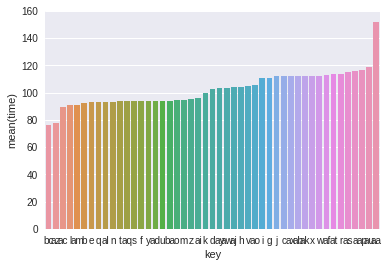

In [43]:
new_pd = new_pd.sort_values('time')
sns.barplot(x='key', y='time', data=new_pd)

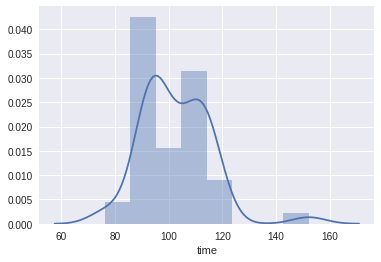

In [37]:
sns.distplot(new_pd['time'])

In [48]:
new_pd['key'].loc[(new_pd['time'] > 80) == (new_pd['time'] < 95 )]

44    ac
41     l
16    am
34     b
24     e
18     q
3     al
9      n
2      t
27    aq
8      s
11     f
13     y
38    ad
37     u
30    ba
4      o
40     m
Name: key, dtype: object

In [3]:
cat_columns = list()
for i in train_df.columns:
    if train_df[i].dtype == 'object':
        cat_columns.append(i)

In [4]:
new_dfs_to_concat = list()
for i in cat_columns:
    new_df = pd.get_dummies(full_df[i], prefix=i)
    new_dfs_to_concat.append(new_df)

In [5]:
for i in new_dfs_to_concat:
    full_df = pd.concat([full_df, i], axis=1)
for i in cat_columns:
    full_df = full_df.drop(i,1)
full_df.head()

,ID,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0677366790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0674c3cd50>]], dtype=object)

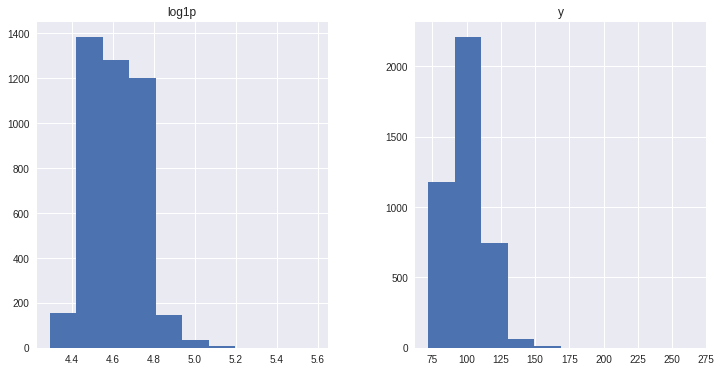

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
times = pd.DataFrame({'y':train_df['y'], 'log1p': np.log1p(train_df['y'])})
times.hist()

In [7]:
y = np.log1p(train_df['y'])
X_train = full_df[:4209]
X_test = full_df[4209:]
print X_train.shape
print X_test.shape

(4209, 581)
(4209, 581)


In [8]:
X_train = X_train.drop(['ID', 'y'], 1)
X_test = X_test.drop(['ID','y'], 1)

In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=3))
    return rmse

In [10]:
model_ridge = Ridge()

In [11]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
           for alpha in alphas]

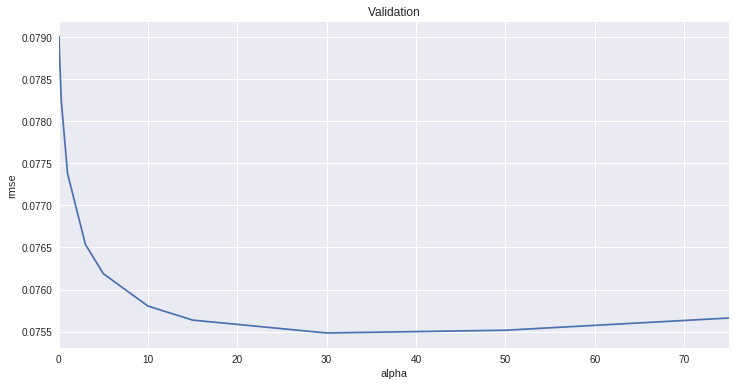

In [12]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [13]:
cv_ridge.min()

0.075484743347469338

In [89]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [90]:
rmse_cv(model_lasso).mean()

0.075127928448563017

In [91]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [92]:
print 'Lasso picked '+str(sum(coef != 0)) +' variables and got rid of '+str(sum(coef==0))

Lasso picked 57 variables and got rid of 522


In [93]:
print coef['X120']

-0.00810494330988


In [94]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

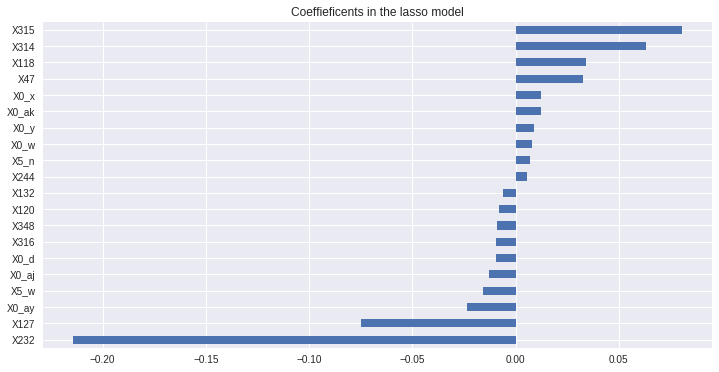

In [95]:
matplotlib.rcParams['figure.figsize'] = (12., 6.0)
imp_coef.plot(kind='barh')
plt.title('Coeffieficents in the lasso model')

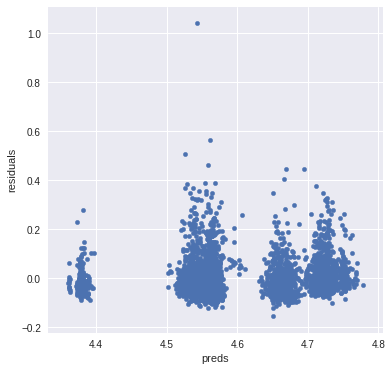

In [96]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'true': y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x='preds', y='residuals', kind='scatter')

In [97]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [51]:
#Doing NEW paramter boosting here
def model_fit(alg, xtrain, y, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,
                         metrics = 'rmse', early_stopping_rounds = early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the alg to the data
    alg.fit(xtrain, y, eval_metric='rmse')
    
    #Predict Training set:
    dtrain_predictions = alg.predict(xtrain)
    #Print model report
    print 'The best number of iterations is:'+str(cvresult.shape[0])
    print '\nModel report'
    #print 'Accuracy : %.4g' % metrics.accuracy_score(y, dtrain_predictions)
    print 'RMSE score : %f' % metrics.mean_squared_error(y, dtrain_predictions)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importance')
    plt.ylabel('Feature Importance score')

In [52]:
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)
params = {'max_depth':2, 'eta':0.1}
#model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds = 100)

In [1]:
train_df.sample(5)

NameError: name 'train_df' is not defined

The best number of iterations is:146

Model report
RMSE score : 0.004498


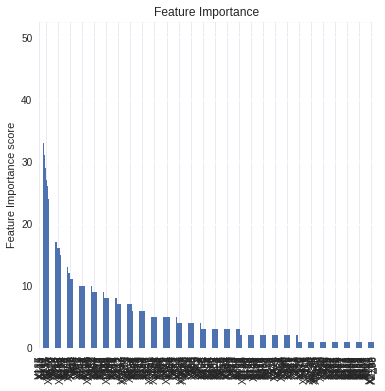

In [57]:
#Still new paramter tuning
xgb1 = xgb.XGBRegressor(learning_rate =0.05,
                       n_estimators = 1000,
                        max_depth=5,
                        min_child_weight = 1,
                        gamma = 0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        seed=23)
model_fit(xgb1, X_train,y)
                        

In [62]:
param_test1 = {
    'max_depth': [2,3,4],
    'min_child_weight': [6,7,8]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1, n_estimators=68, max_depth=5,
                                                                            min_child_weight = 1,
                        gamma = 0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        seed=23),
                        param_grid=param_test1, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.00554, std: 0.00112, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -0.00554, std: 0.00112, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: -0.00554, std: 0.00112, params: {'max_depth': 2, 'min_child_weight': 8},
  mean: -0.00553, std: 0.00112, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.00553, std: 0.00112, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.00553, std: 0.00112, params: {'max_depth': 3, 'min_child_weight': 8},
  mean: -0.00556, std: 0.00112, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.00556, std: 0.00112, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: -0.00555, std: 0.00111, params: {'max_depth': 4, 'min_child_weight': 8}],
 {'max_depth': 3, 'min_child_weight': 8},
 -0.0055298656027848595)

In [67]:
param_test_3 = {
    'gamma': [i/10.0 for i in range(0, 5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     n_estimators=68,
                                                     max_depth = 3,
                                                     min_child_weight=6,
                                                     gamma=0,
                                                     subsample=0.8,
                                                     colsample_bytree=0.8,
                                                     seed=23
                                                     ),
                         param_grid = param_test_3, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train, y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.00553, std: 0.00112, params: {'gamma': 0.0},
  mean: -0.00560, std: 0.00109, params: {'gamma': 0.1},
  mean: -0.00573, std: 0.00108, params: {'gamma': 0.2},
  mean: -0.00584, std: 0.00110, params: {'gamma': 0.3},
  mean: -0.00591, std: 0.00111, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.005532068106549675)

The best number of iterations is:67

Model report
RMSE score : 0.004196


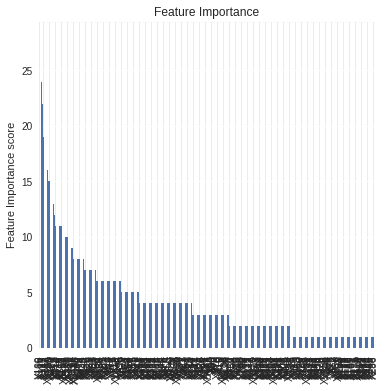

In [80]:
#get new number of boosting rounds based on updated params
xgb2 = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 6,
    min_child_weight =1,
    gamma = 0,
    subsample=0.8,
    colsample_bytree=0.8,
    seed=23)
model_fit(xgb2, X_train, y)

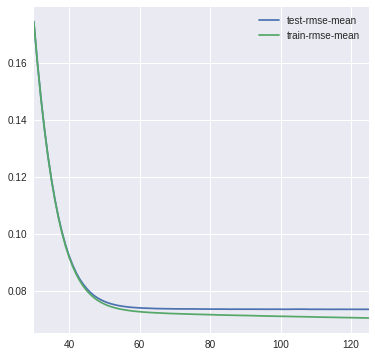

In [24]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [83]:
xgb2.fit(X_train, y)
xgb_preds_new = np.expm1(xgb2.predict(X_test))

In [84]:
new_sols = pd.DataFrame({'ID': test_df['ID'], 'y': xgb_preds_new})

In [25]:
model_xgb = xgb.XGBRegressor(n_estimators = 100, max_depth=2, learning_rate=0.7)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.7, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [98]:
#xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

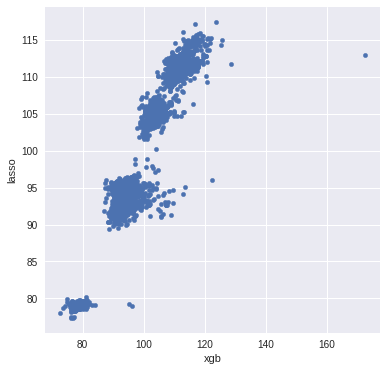

In [27]:
predictions = pd.DataFrame({'xgb': xgb_preds, 'lasso': lasso_preds})
predictions.plot(x='xgb', y='lasso', kind='scatter')

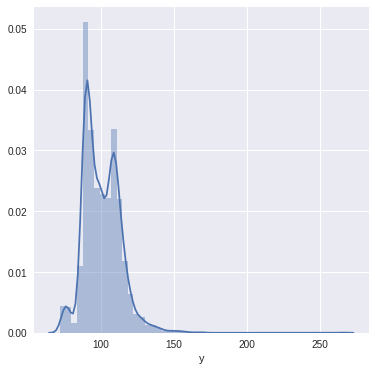

In [28]:
sns.distplot(train_df['y'])

In [29]:
#Best split so far is 70 lasso 30 xgb
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [30]:
solution = pd.DataFrame({'ID': test_df['ID'], 'y': preds})
solution.shape

(4209, 2)

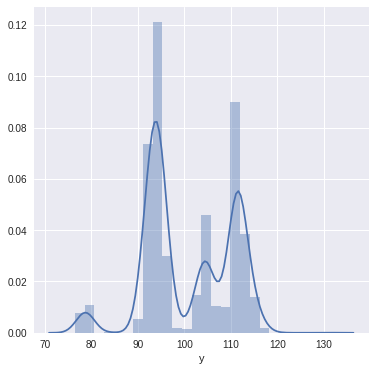

In [31]:
sns.distplot(solution['y'])

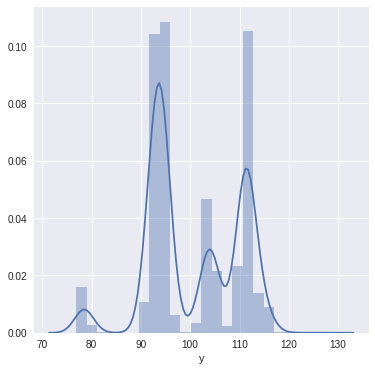

In [101]:
new_sols.head()
new_sols['y'] = 0.5*lasso_preds + 0.5*xgb_preds_new
sns.distplot(new_sols['y'])
new_sols.to_csv('tundex_xgb_55.csv', index=False)

In [32]:
solution.to_csv('new_cats_64split.csv', index=False)

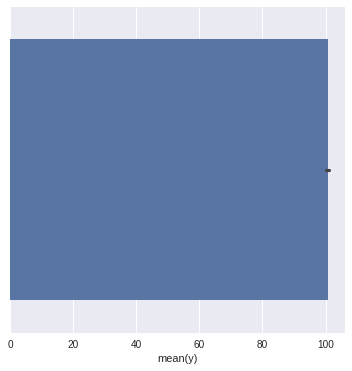

In [33]:
sns.barplot(train_df['y'], hue=train_df['X232'])

In [34]:
print sum(train_df['X232'] == 0)

4028


In [35]:
#try random forests here
print X_train.head()
print X_test.head()

   X10  X100  X101  X102  X103  X104  X105  X106  X107  X108  ...   X8_p  \
0    0     0     0     0     0     0     0     0     0     0  ...      0   
1    0     1     1     0     0     0     0     0     0     0  ...      0   
2    0     0     1     0     0     0     0     0     0     0  ...      0   
3    0     0     1     0     0     0     0     0     0     1  ...      0   
4    0     0     1     0     0     0     0     0     0     1  ...      0   

   X8_q  X8_r  X8_s  X8_t  X8_u  X8_v  X8_w  X8_x  X8_y  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     1     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 579 columns]
      X10  X100  X101  X102  X103  X104  X105  X106  X107  X108  ...   X8_p  \
4209    0     0     1     0     0     0     0     0     0     0  ...      0   
4210    0    

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [37]:
rf = RandomForestRegressor()
rf.fit(X_train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [38]:
rf_preds = np.expm1(rf.predict(X_test))

In [39]:
rf_preds = pd.DataFrame({'ID': test_df['ID'], 'y':rf_preds})

In [40]:
rf_preds.head()

,ID,y
0,1,77.409100
1,2,102.045488
2,3,77.194197
3,4,78.087302
4,5,110.176746


In [41]:
solution.head()

,ID,y
0,1,84.085509
1,2,99.748622
2,3,84.214694
3,4,78.063880
4,5,111.247322


In [42]:
rf_preds.to_csv('base_rf_preds.csv', index=False)

In [43]:
all_sols = rf_preds

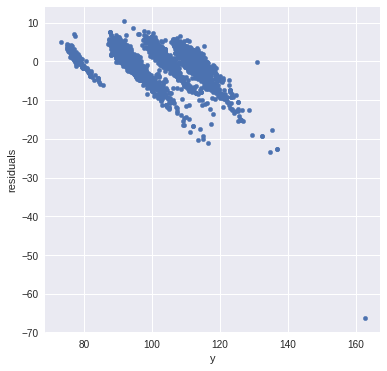

In [44]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
all_sols['residuals'] = solution['y'] - all_sols['y']
all_sols.plot(x='y', y='residuals', kind='scatter')

In [46]:
from treeinterpreter import treeinterpreter as ti

ImportError: No module named treeinterpreter

In [60]:
feat_impor = pd.DataFrame({'feat':X_test.columns, 'weight':rf.feature_importances_})

In [69]:
feat_impor = feat_impor.sort_values('weight', ascending=False)

,feat,weight
230,X314,0.405838
175,X263,0.049367
231,X315,0.045016
204,X29,0.030922
29,X127,0.030245


In [83]:
sum(feat_impor['weight'] !=0)

482

In [84]:
coef.index

Index([u'X10', u'X100', u'X101', u'X102', u'X103', u'X104', u'X105', u'X106',
       u'X107', u'X108',
       ...
       u'X8_p', u'X8_q', u'X8_r', u'X8_s', u'X8_t', u'X8_u', u'X8_v', u'X8_w',
       u'X8_x', u'X8_y'],
      dtype='object', length=579)

In [85]:
coef['X120']

-0.0081049433098771828

In [87]:
cols_to_drop = list()
for i in coef.index:
    if coef[i] == 0:
        cols_to_drop.append(i)

In [90]:
new_x_train = X_train
new_x_test = X_test
for i in cols_to_drop:
    new_x_train = new_x_train.drop(i, 1)
    new_x_test = new_x_test.drop(i, 1)
print new_x_test.shape

(4209, 57)


In [96]:
#Trying new random forest with less features
new_rf = RandomForestRegressor()
new_rf.fit(new_x_train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [98]:
new_rf_preds = np.expm1(new_rf.predict(new_x_test))
new_rf_sols = pd.DataFrame({'ID': test_df['ID'], 'y': new_rf_preds})
new_rf_sols.shape

(4209, 2)

In [100]:
new_rf_sols['residuals'] = rf_preds['y'] - new_rf_sols['y']
new_rf_sols.head()

,ID,y,residuals
0,1,77.555612,-0.146512
1,2,90.419762,11.625726
2,3,73.774307,3.419890
3,4,76.727773,1.359529
4,5,120.291799,-10.115054


In [94]:
rf_preds.head()

,ID,y,residuals
0,1,77.409100,6.676409
1,2,102.045488,-2.296866
2,3,77.194197,7.020497
3,4,78.087302,-0.023423
4,5,110.176746,1.070576


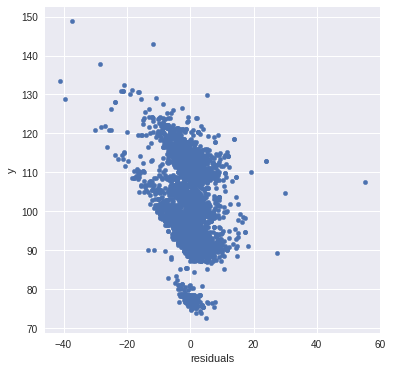

In [101]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
new_rf_sols.plot(x='residuals', y='y', kind='scatter')

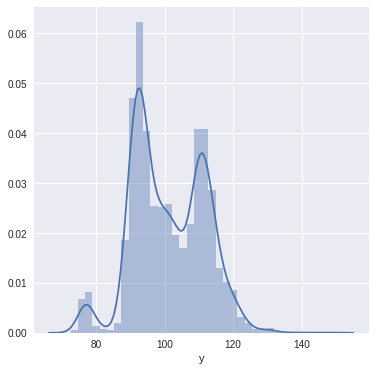

In [102]:
sns.distplot(new_rf_sols['y'])

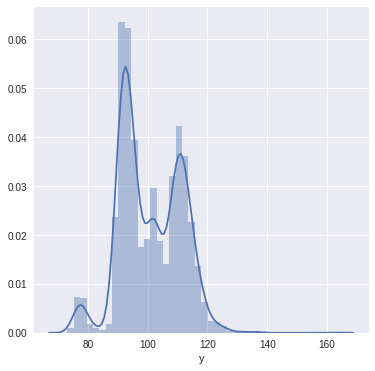

In [104]:
sns.distplot(rf_preds['y'])

In [105]:
new_rf_sols = new_rf_sols.drop('residuals', 1)
new_rf_sols.to_csv('new_rf_less_cat.csv', index=False)